# Difference in significance between `cash` and `wstat` analysis

Method:
- Simultate an extended gaussian using the IRF background (`MapDataset`)
- Create a `MapDatasetOnOff` from the thus simulated `MapDataset` using the `RingBackGroundMaker`
- Fit these datasets
- Compare the results for the two cases
- Do this in a loop to compare see if systematic

Standard imports

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.makers import RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator
from regions import CircleSkyRegion
from scipy.stats import norm, chi2
from gammapy.maps import Map

## Do a binned simulation using DC1 IRFs

In [21]:
# Load the irfs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

# Define the observation parameters
livetime = 3.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 2), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(4, 4),
    frame="galactic",
    axes=[energy_reco],
)

In [22]:
# Define sky model to used simulate the data.

spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.4 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="5e-13 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model_simu",
)

In [23]:
def simulate():
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    empty = MapDataset.create(geom, name="dataset-simu")
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models.append(model_simu)
    dataset.fake()
    return dataset

In [24]:
datasets = []
for i in range(20):
    datasets.append(simulate())

## Cash statistics - fitting and excess maps

In [25]:
# Define sky model to fit the data
spatial_model1 = GaussianSpatialModel(
    lon_0="0.1 deg", lat_0="0.1 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model1 = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(
    spatial_model=spatial_model1,
    spectral_model=spectral_model1,
    name="model-fit",
)
model_fit.spectral_model.parameters['index'].frozen = True

In [26]:
def fitting_cash(dataset):
    # Make a copy of the dataset
    dataset_fit = dataset.copy(name="dataset-fit")
    dataset_fit.models["dataset-simu-bkg"].datasets_names = ["dataset-fit"]
    dataset_fit.models.remove('model_simu')
    L0 = dataset_fit.stat_sum()
    dataset_fit.models = [model_fit, dataset_fit.models[0]]
    fit = Fit([dataset_fit])
    result = fit.run(optimize_opts={"print_level": 0})
    L1 = dataset_fit.stat_sum()
    e1 = result.parameters['amplitude'].error
    e2 = result.parameters['sigma'].error
    return e1, e2, L0-L1

In [27]:
err_amp_cs = []
err_sig_cs = []
delL = []
for dataset in datasets:
    e1, e2, dl = fitting_cash(dataset)
    err_amp_cs.append(e1)
    err_sig_cs.append(e2)
    delL.append(dl)

(array([7., 2., 2., 1., 2., 4., 1., 0., 0., 1.]),
 array([243.63060522, 256.90676118, 270.18291713, 283.45907309,
        296.73522905, 310.011385  , 323.28754096, 336.56369692,
        349.83985287, 363.11600883, 376.39216479]),
 <a list of 10 Patch objects>)

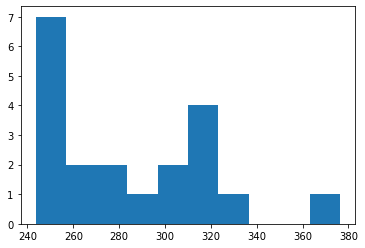

In [28]:
plt.hist(delL)

## WSTAT - Ring background

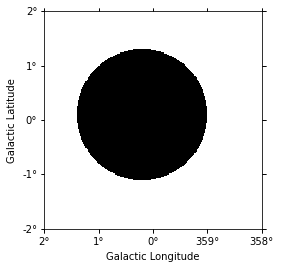

In [29]:
# Make the exclusion mask
source_pos = model_simu.position
regions = CircleSkyRegion(center=source_pos, radius=1.2 * u.deg)
exclusion_mask = Map.from_geom(geom)
exclusion_mask.data = geom.region_mask([regions], inside=False)
exclusion_mask.sum_over_axes().plot();

In [30]:
ring_maker = RingBackgroundMaker(
    r_in="1.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)


In [31]:
# Define sky model to fit the data
spatial_model2 = GaussianSpatialModel(
    lon_0="0.1 deg", lat_0="0.1 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model2 = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit2 = SkyModel(
    spatial_model=spatial_model2,
    spectral_model=spectral_model2,
    name="model-fit2",
)
model_fit2.spectral_model.parameters['index'].frozen = True

In [32]:
def fit_ring(dataset):
    dataset_on_off = ring_maker.run(dataset)
    dataset_on_off.psf = dataset.psf
    L2 = dataset_on_off.stat_sum()
    dataset_on_off.models = model_fit2
    fit2 = Fit([dataset_on_off])
    result2 = fit2.run(optimize_opts={"print_level": 0})
    L3 = dataset_on_off.stat_sum()
    e1 = result2.parameters['amplitude'].error
    e2 = result2.parameters['sigma'].error
    return e1, e2, L2-L3

In [33]:
err_amp_ws = []
err_sig_ws = []
delL_onoff = []
for dataset in datasets:
    e1, e2, dl = fit_ring(dataset)
    err_amp_ws.append(e1)
    err_sig_ws.append(e2)
    delL_onoff.append(dl)

No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset dataset-simu
No background model defined for dataset datase

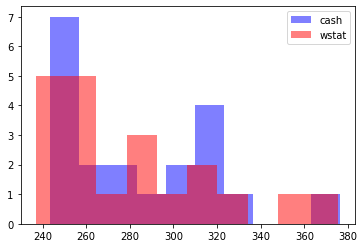

In [34]:
plt.hist(delL, alpha=0.5, color='blue', label="cash")
plt.hist(delL_onoff, alpha=0.5, color='red', label="wstat")
plt.legend()

In [35]:
np.mean(delL),  np.std(delL)

(284.9295558929654, 35.681159430970844)

In [36]:
np.mean(delL_onoff), np.std(delL_onoff)

(280.04986559761676, 37.09418429882665)

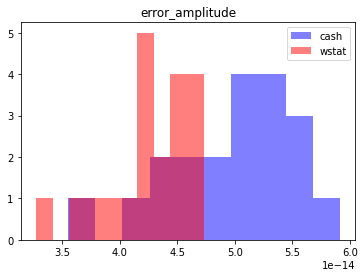

In [37]:
plt.hist(err_amp_cs, alpha=0.5, color='blue', label="cash")
plt.hist(err_amp_ws, alpha=0.5, color='red', label="wstat")
plt.title("error_amplitude")
plt.legend()

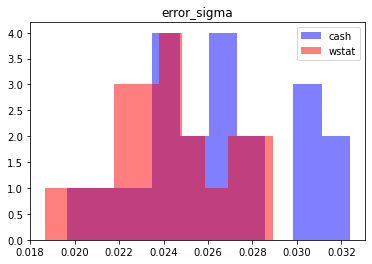

In [38]:
plt.hist(err_sig_cs, alpha=0.5, color='blue', label="cash")
plt.hist(err_sig_ws, alpha=0.5, color='red', label="wstat")
plt.title("error_sigma")
plt.legend()